In [1]:
# Set environmental variables with google service credentials
import os
%env GOOGLE_APPLICATION_CREDENTIALS=/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json
print(os.getenv('GOOGLE_APPLICATION_CREDENTIALS'))

env: GOOGLE_APPLICATION_CREDENTIALS=/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json
/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json


In [2]:
# import necessary libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from google.cloud import bigquery

bqclient = bigquery.Client()

In [3]:
# Test BQ Connect
def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

implicit()

[]


In [4]:
# Download query results.
top_rank_categories_2020 = """
WITH monthy_cat_sales_2020 AS 
(
SELECT
    DATE_TRUNC(date, month) AS year_month,
    category_name,
    vendor_name,
    SUM(sale_dollars) AS total_sales,
    SUM(bottles_sold) AS total_bottles,
    AVG(pack) AS avg_pack_size,
    AVG((state_bottle_retail - state_bottle_cost) / state_bottle_retail) AS margins
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date between'2020-01-01' AND '2020-12-31'
    AND category_name IS NOT NULL
GROUP BY 1, 2, 3
ORDER BY 1
),
monthly_ranking_by_cat AS (
SELECT 
    year_month, 
    category_name,
    vendor_name,
    total_sales,
    total_bottles,
    avg_pack_size,
    margins,
    RANK() OVER (PARTITION BY year_month ORDER BY total_bottles DESC) AS ranking
FROM monthy_cat_sales_2020
ORDER BY 1, 8)

SELECT 
    year_month, 
    category_name,
    vendor_name,
    total_sales,
    total_bottles,
    avg_pack_size,
    margins,
    ranking
FROM monthly_ranking_by_cat
WHERE ranking BETWEEN 1 AND 20
"""

top_rank_categories_2020 = (
    bqclient.query(top_rank_categories_2020)
    .result()
    .to_dataframe(
        create_bqstorage_client=True,
    )
)

## Promoting below average rank of 10 of each month
With the big brands dominating monthly sales in the vodka and whiskey categories, the marketing team can look to brands and categories between 5-10 ranks. These brands and categories' high sales volume indicates demand from consumers and also something for loyal customers of other brands and categories to try something new and outside their regular purchases.

### **Frequency of appearance in the monthly top 20**

In [5]:
top_rank_categories_2020[['vendor_name','category_name']].value_counts()

vendor_name                     category_name                 
McCormick Distilling Co.        American Vodkas                   12
Brown Forman Corp.              Tennessee Whiskies                12
MOET HENNESSY USA               Imported Brandies                 12
SAZERAC NORTH AMERICA           American Vodkas                   12
SAZERAC COMPANY  INC            Whiskey Liqueur                   12
DIAGEO AMERICAS                 American Vodkas                   12
                                Canadian Whiskies                 12
                                Spiced Rum                        12
Laird & Company                 American Vodkas                   12
PROXIMO                         Mixto Tequila                     12
FIFTH GENERATION INC            American Vodkas                   12
Heaven Hill Brands              Canadian Whiskies                 12
LUXCO INC                       American Vodkas                   12
Jim Beam Brands                 Straight

Top brands such as DIAGEO AMERICAS, FIFTH GENERATION INC, Heaven Hill Brands feature strongly in the top 10 rankings each month

### **Average Rank of brands in monthly top 20**

In [6]:
top_rank_categories_2020.groupby(['vendor_name','category_name'])['ranking'].mean().sort_values(ascending=False)

vendor_name                     category_name                 
E & J Gallo Winery              American Brandies                 20.000000
CONSTELLATION BRANDS INC        Imported Vodkas                   20.000000
PERNOD RICARD USA               Imported Vodkas                   19.000000
SAZERAC COMPANY  INC            American Vodkas                   18.666667
BACARDI USA INC                 White Rum                         18.375000
E & J Gallo Winery              American Flavored Vodka           17.875000
Jim Beam Brands                 American Schnapps                 17.600000
REMY COINTREAU USA INC          Imported Brandies                 17.500000
PERNOD RICARD USA               Flavored Rum                      17.444444
CONSTELLATION BRANDS INC        American Brandies                 17.000000
DIAGEO AMERICAS                 American Flavored Vodka           17.000000
Heaven Hill Brands              Spiced Rum                        16.714286
PERNOD RICARD USA        

Identifying brands that are just out of the top 5 in average rankings throughout 2020, such as Jim Bean Brands, PROXIMO, MOET HENNESSY USA, shows consumer demand in sales and have potential to do well if priced well and promoted in stores

### **Total bottles sold each month by top 20 brands**

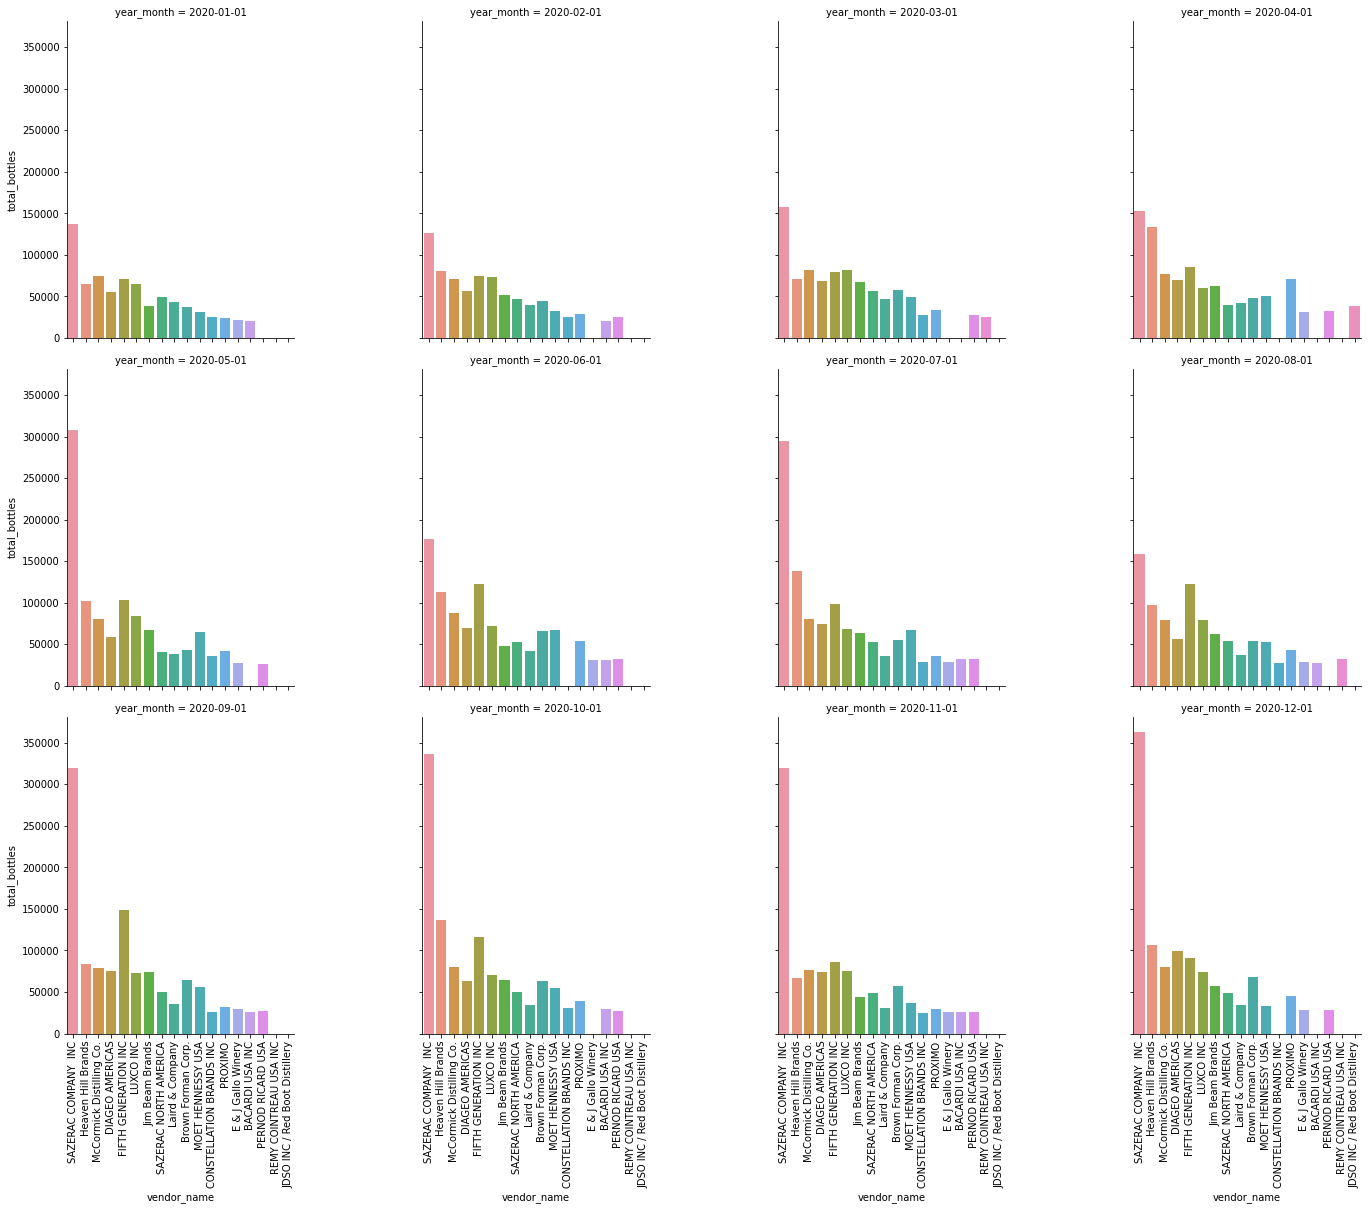

In [7]:
# Plot top categories by county
g = sns.catplot(y="total_bottles", x='vendor_name', col="year_month",
                data=top_rank_categories_2020, col_wrap=4, kind="bar", ci=None)
g.set_xticklabels(rotation=90)
g.fig.set_size_inches(20,15)

### **Total bottles sold each month by top 20 Categories**

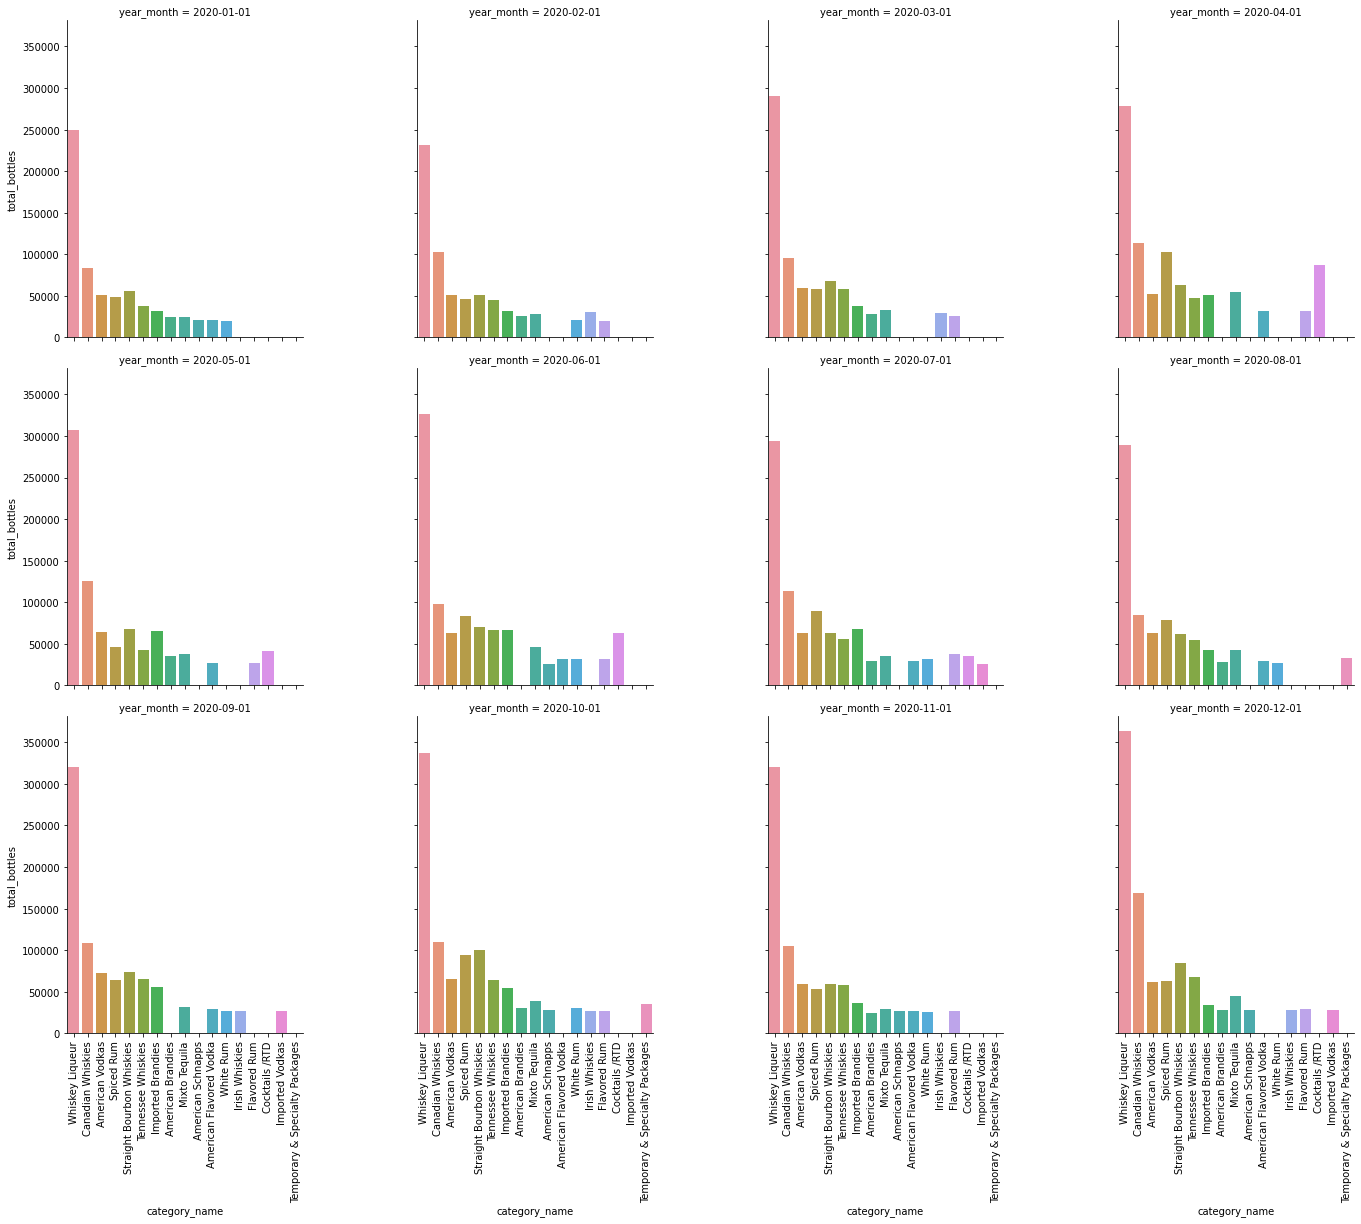

In [8]:
# Plot top categories by county
g = sns.catplot(y="total_bottles", x='category_name', col="year_month",
                data=top_rank_categories_2020, col_wrap=4, kind="bar", ci=None)
g.set_xticklabels(rotation=90)
g.fig.set_size_inches(20,15)